In [1]:
from datetime import datetime
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
! ls ../data/

T1.csv


In [3]:
sc = SparkSession.builder.appName("Cheatsheet").getOrCreate()

In [4]:
custom_date_parser = lambda x: datetime.strptime(x, "%d %m %Y %H:%M")

# Reading CSV in pandas
df = pd.read_csv("../data/T1.csv",
                 parse_dates=["Date/Time"],
                 date_parser=custom_date_parser
                )

# Reading CSV in PySpark
spark_df = sc.read.options(
    header=True,
    inferSchema=True,
    timestampFormat="dd MM y HH:mm"
).csv("../data/T1.csv")

In [5]:
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [6]:
spark_df.show(5)

+-------------------+-------------------+----------------+-----------------------------+------------------+
|          Date/Time|LV ActivePower (kW)|Wind Speed (m/s)|Theoretical_Power_Curve (KWh)|Wind Direction (°)|
+-------------------+-------------------+----------------+-----------------------------+------------------+
|2018-01-01 00:00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|2018-01-01 00:10:00|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|2018-01-01 00:20:00|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|2018-01-01 00:30:00|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|2018-01-01 00:40:00|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+-------------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows



## Resampling time series

**Note:** Renaming the columns to improve the productivity while writing code.

In [7]:
df = df.rename(columns={
    "Date/Time": "timestamp",
    "LV ActivePower (kW)": "active_pwr",
    "Wind Speed (m/s)": "wind_speed",
    "Theoretical_Power_Curve (KWh)": "theoretical_pwr",
    "Wind Direction (°)": "wind_dir"
})


spark_df = spark_df.withColumnRenamed("Date/Time", "timestamp") \
.withColumnRenamed("LV ActivePower (kW)", "active_pwr") \
.withColumnRenamed("Wind Speed (m/s)", "wind_speed") \
.withColumnRenamed("Theoretical_Power_Curve (KWh)", "theoretical_pwr") \
.withColumnRenamed("Wind Direction (°)", "wind_dir")

In [8]:
df.head()

,timestamp,active_pwr,wind_speed,theoretical_pwr,wind_dir
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [21]:
import matplotlib.pyplot as plt

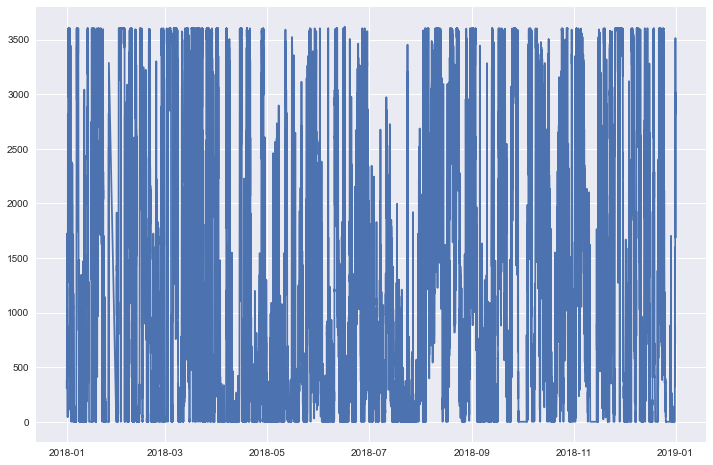

In [26]:
plt.style.use('seaborn')

plt.figure(figsize=(12, 8))
plt.plot(df['timestamp'], df['active_pwr'])
plt.show()

In [9]:
spark_df.show(5)

+-------------------+----------------+----------------+----------------+----------------+
|          timestamp|      active_pwr|      wind_speed| theoretical_pwr|        wind_dir|
+-------------------+----------------+----------------+----------------+----------------+
|2018-01-01 00:00:00|380.047790527343|5.31133604049682|416.328907824861|259.994903564453|
|2018-01-01 00:10:00| 453.76919555664|5.67216682434082|519.917511061494| 268.64111328125|
|2018-01-01 00:20:00|306.376586914062|5.21603679656982|390.900015810951|272.564788818359|
|2018-01-01 00:30:00|419.645904541015|5.65967416763305|516.127568975674|271.258087158203|
|2018-01-01 00:40:00|380.650695800781|5.57794094085693|491.702971953588|265.674285888671|
+-------------------+----------------+----------------+----------------+----------------+
only showing top 5 rows



In [52]:
spark_df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- active_pwr: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- theoretical_pwr: double (nullable = true)
 |-- wind_dir: double (nullable = true)



**Note:** In the following cells I'll be resampling the 10 min data to 1 hour

### Resampling in pandas

In [10]:
df_to_resample = df.set_index("timestamp")

df_resample = df_to_resample.resample("1H").agg(
    {
        "active_pwr": "sum",
        "wind_speed": "mean",
        "theoretical_pwr": "sum",
        "wind_dir": "mean"
    }
)

### Resampling in PySpark

In [106]:
agg_by_cols = [
    F.sum("active_pwr").alias("active_pwr")
]


from datetime import datetime

downsample_window = F.window("timestamp", "60 minutes", slideDuration="60 minutes", startTime="30 minutes")

spark_resampled_df = spark_df.groupBy(downsample_window).agg(*agg_by_cols)
spark_resampled_df = spark_resampled_df.select(
    "window.start",
    "window.end",
    "active_pwr"
)

spark_resampled_df = spark_resampled_df.sort("start")

spark_resampled_df.show()

+-------------------+-------------------+------------------+
|              start|                end|        active_pwr|
+-------------------+-------------------+------------------+
|2018-01-01 00:00:00|2018-01-01 01:00:00| 2342.882171630856|
|2018-01-01 01:00:00|2018-01-01 02:00:00|2763.2227478027335|
|2018-01-01 02:00:00|2018-01-01 03:00:00| 4401.932250976559|
|2018-01-01 03:00:00|2018-01-01 04:00:00| 5456.172485351558|
|2018-01-01 04:00:00|2018-01-01 05:00:00|  8361.10913085935|
|2018-01-01 05:00:00|2018-01-01 06:00:00|  6897.59497070309|
|2018-01-01 06:00:00|2018-01-01 07:00:00| 6600.446350097644|
|2018-01-01 07:00:00|2018-01-01 08:00:00|5569.4569091796775|
|2018-01-01 08:00:00|2018-01-01 09:00:00|3687.9185485839816|
|2018-01-01 09:00:00|2018-01-01 10:00:00| 4029.050445556639|
|2018-01-01 10:00:00|2018-01-01 11:00:00|3129.7532806396457|
|2018-01-01 11:00:00|2018-01-01 12:00:00| 1105.094589233396|
|2018-01-01 12:00:00|2018-01-01 13:00:00| 763.9549064636224|
|2018-01-01 13:00:00|201